In [1]:
''' In this ipynb file, features are extracted from a pretrained ImageNet CNN,
    and then used to train a Logistic Regression model, and then a k-nearest neighbors
    model. Acuraccy, precision, etc. and confusion matrix are shown for both.
'''
from PIL import Image
import numpy as np
import os
import torch
import torchvision
import torchvision.models as models
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision import transforms

In [2]:
#To connect to the drive where the datasets are present
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset3_path = "/content/drive/My Drive/Colab Notebooks/Comp 432 Project/COMP432-GroupP/Dataset 3/Animal Faces"
#Define basic transform function
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset3 = torchvision.datasets.ImageFolder(root=dataset3_path, transform = data_transform)

In [14]:
def dataset_show_images(dataset, numImages:int, classes:list, shuffle=True):
  print('Diplaying ', numImages,  ' random images:\n')

  loader = torch.utils.data.DataLoader(dataset, batch_size=numImages, shuffle=shuffle)
  batch = next(iter(loader))
  images, labels = batch
  grid = torchvision.utils.make_grid(images, nrow = int(numImages/2))
  plt.figure(figsize=(11,11))
  plt.imshow(np.transpose(grid, (1,2,0)))

Diplaying  8  random images:



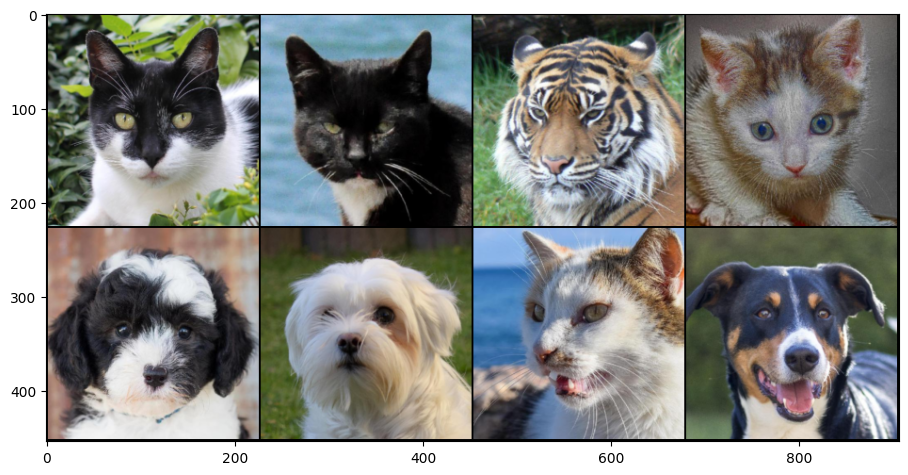

In [19]:
dataset3_classes = dataset3.classes
dataset_show_images(dataset3, 8, dataset3_classes, True)

In [20]:
print(dataset3_classes)

['cat', 'dog', 'wild']


In [4]:
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.eval()

def preprocess_dataset_3(directory_path):
    categories = ['cat', 'dog', 'wild']
    processed_images = []
    allowed_extensions = {'jpg', 'jpeg', 'png', 'bmp', 'gif'}

    for category in categories:
        folder_path = os.path.join(directory_path, category)
        for image_file in os.listdir(folder_path):
            if image_file.split('.')[-1].lower() in allowed_extensions:
                image_path = os.path.join(folder_path, image_file)
                with Image.open(image_path) as img:
                    img_resized = img.resize((224, 224))
                    img_array = np.asarray(img_resized) / 255.0
                    processed_images.append((img_array, category))
    return processed_images

def extract_features(preprocessed_images):
    count = 0
    features = []
    labels = []
    for img_array, category in preprocessed_images:
        image_tensor = torch.tensor(img_array).unsqueeze(0).permute(0, 3, 1, 2)
        with torch.no_grad():
            feature = model(image_tensor.float())
        features.append(feature.flatten().numpy())
        labels.append(category)
        count+=1
        if(count%20==0):
          print(count)
    return np.array(features), labels


def visualize_features(features, labels):
    tsne = TSNE(n_components=2, random_state=0)
    reduced_features = tsne.fit_transform(features)

    unique_labels = list(set(labels))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    plt.figure(figsize=(8, 8))
    for i, label in enumerate(unique_labels):
        indices = [j for j, x in enumerate(labels) if x == label]
        plt.scatter(reduced_features[indices, 0], reduced_features[indices, 1], color=colors[i], label=label)
    plt.legend()
    plt.title("Feature Visualization with t-SNE")
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


In [5]:
dataset_3_processed = preprocess_dataset_3(dataset3_path)

In [ ]:
# feature extraction
features, labels = extract_features(dataset_3_processed)

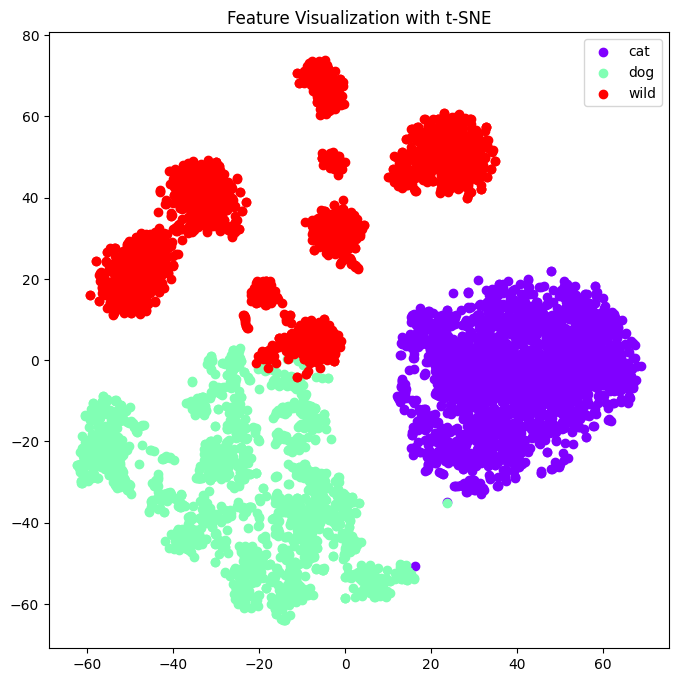

In [7]:
visualize_features(features, labels)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Encode the labels into numbers for training
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# shuffle
indices = np.arange(len(features))
np.random.shuffle(indices)
shuffled_features = features[indices]
shuffled_labels = encoded_labels[indices]

In [9]:
# Training LR on the extracted features
X_train, X_test, y_train, y_test = train_test_split(shuffled_features, shuffled_labels, test_size=0.2, random_state=0)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Testing
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       394
           1       0.99      1.00      0.99       401
           2       1.00      0.99      0.99       409

    accuracy                           0.99      1204
   macro avg       0.99      0.99      0.99      1204
weighted avg       0.99      0.99      0.99      1204



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
from sklearn.metrics import confusion_matrix
# Confusion matrix
def plot_confusion_matrix(y_test, y_pred, title):
  # decode the labels back into words for display
  y_test_decoded = label_encoder.inverse_transform(y_test)
  y_pred_decoded = label_encoder.inverse_transform(y_pred)

  conf_matrix = confusion_matrix(y_test_decoded, y_pred_decoded)

  plt.figure(figsize=(8, 6))
  plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  plt.colorbar()

  classes = np.unique(np.concatenate((y_test_decoded, y_pred_decoded)))
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  for i in range(conf_matrix.shape[0]):
      for j in range(conf_matrix.shape[1]):
          plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='black', fontsize=12)

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

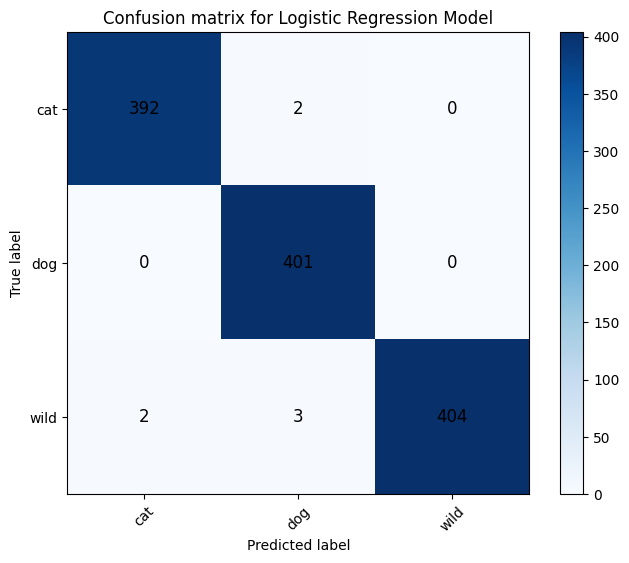

In [13]:
plot_confusion_matrix(y_test, y_pred, 'Confusion matrix for Logistic Regression Model')

In [14]:
# Now, let's fit the same features to a k-nearest neighbors clustering model
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

# Testing
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report:')
print(classification_report(y_test, y_pred))


Accuracy: 1.00
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       1.00      1.00      1.00       401
           2       1.00      1.00      1.00       409

    accuracy                           1.00      1204
   macro avg       1.00      1.00      1.00      1204
weighted avg       1.00      1.00      1.00      1204



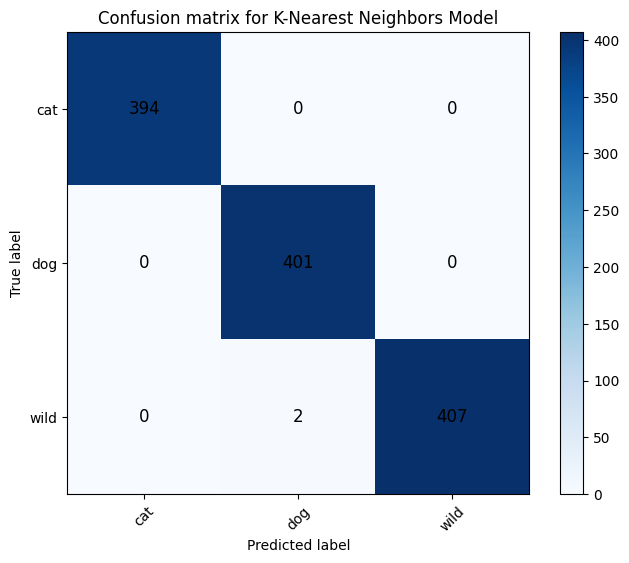

In [15]:
plot_confusion_matrix(y_test, y_pred, 'Confusion matrix for K-Nearest Neighbors Model')

In [ ]:
# As we can see, the accuracies for both are very high, about 99%, which is rare. However, unlike the other 2 datasets, this dataset is very separable
# given that even the tSNE shows very well isolated clusters, so the high accuracy is justifiable.